In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('ulasan_digitalent.csv')
df.head()

,userName,score,content,at
0,Feby Ade,5,sangat menarik,2025-07-13 21:27:14
1,idham vidi tamuliko,2,loginnya ribet,2025-07-13 18:27:05
2,ari purnomo aji,5,bagus untuk pengembangan diri secara mandiri,2025-07-13 12:31:52
3,Cici Sukarsi,5,"program yg bagus, tolong dilanjutkan!",2025-07-12 15:30:07
4,Abdul Rohman,5,mantap,2025-07-10 20:14:32


In [8]:
df = df.drop(columns=['nama_pengguna', 'tanggal'], errors='ignore')
df.head()

,userName,score,content,at
0,Feby Ade,5,sangat menarik,2025-07-13 21:27:14
1,idham vidi tamuliko,2,loginnya ribet,2025-07-13 18:27:05
2,ari purnomo aji,5,bagus untuk pengembangan diri secara mandiri,2025-07-13 12:31:52
3,Cici Sukarsi,5,"program yg bagus, tolong dilanjutkan!",2025-07-12 15:30:07
4,Abdul Rohman,5,mantap,2025-07-10 20:14:32


In [9]:
def label_bintang(score):
    if score >= 4:
        return 2  # Positif
    elif score == 3:
        return 1  # Netral
    else:
        return 0  # Negatif

df['label'] = df['score'].apply(label_bintang)
df.head()

,userName,score,content,at,label
0,Feby Ade,5,sangat menarik,2025-07-13 21:27:14,2
1,idham vidi tamuliko,2,loginnya ribet,2025-07-13 18:27:05,0
2,ari purnomo aji,5,bagus untuk pengembangan diri secara mandiri,2025-07-13 12:31:52,2
3,Cici Sukarsi,5,"program yg bagus, tolong dilanjutkan!",2025-07-12 15:30:07,2
4,Abdul Rohman,5,mantap,2025-07-10 20:14:32,2


In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_ulasan'] = df['content'].apply(clean_text)
df[['content', 'cleaned_ulasan', 'label']].head()

,content,cleaned_ulasan,label
0,sangat menarik,menarik,2
1,loginnya ribet,loginnya ribet,0
2,bagus untuk pengembangan diri secara mandiri,bagus pengembangan mandiri,2
3,"program yg bagus, tolong dilanjutkan!",program yg bagus tolong dilanjutkan,2
4,mantap,mantap,2


In [11]:
positive_words = [
    'bagus', 'mantap', 'baik', 'luar biasa', 'keren', 'suka', 'terbaik', 'recommended', 'cepat', 'puas',
    'bermanfaat', 'ok', 'oke', 'keren', 'inspirasi', 'nice', 'membantu', 'menarik', 'pengalaman baik', 'top', 'hebat',
    'sangat membantu', 'sangat bermanfaat', 'pengembangan', 'menambah skill', 'pengalaman bagus', 'the best', 'bagus bgt',
    'mashaallah', 'bermanfaat sekali', 'good', 'aplikasi keren', 'aplikasinya bagus', 'memberikan ilmu', 'luar biasa', 'terima kasih',
    'sangat puas', 'mudah digunakan', 'fitur lengkap', 'pelayanan baik', 'proses mudah', 'user friendly', 'rekomendasi', 'recommended'
]

negative_words = [
    'buruk', 'jelek', 'error', 'lambat', 'tidak bisa', 'payah', 'parah', 'mengecewakan', 'lemot', 'kecewa',
    'ribet', 'gagal', 'susah', 'tidak masuk', 'tidak terkirim', 'tidak sesuai', 'uninstall', 'tidak bisa login', 'tidak bisa daftar',
    'tidak bisa pemulihan', 'tidak bisa akses', 'tidak bisa digunakan', 'tidak bisa validasi', 'tidak bisa reset', 'tidak jelas',
    'masalah', 'keluhan', 'kurang', 'kurang baik', 'kurang bagus', 'kurang memuaskan', 'tidak puas', 'tidak membantu', 'lemot banget',
    'eror', 'gagal login', 'gagal daftar', 'tidak bisa verifikasi', 'tidak pernah masuk', 'tidak pernah terkirim', 'tidak pernah berhasil',
    'hatus pake vpn', 'login susah', 'verifikasi susah', 'reset password', 'kode otp tidak terkirim', 'tidak bisa akses akun'
]

neutral_words = [
    'biasa', 'cukup', 'standard', 'normal', 'lumayan', 'netral', 'tidak ada masalah', 'biasa saja', 'standar', 'cukup baik',
    'cukup bagus', 'tidak terlalu buruk', 'tidak terlalu bagus', '3 dulu', 'belum mencoba', 'baru mau menggunakan', 'belum tahu',
    'belum bisa menilai', 'belum ada pengalaman', 'belum pernah', 'belum digunakan', 'belum mencoba fitur', 'belum tahu banyak'
]

# Bandingkan label otomatis dengan keyword
def keyword_sentiment(text):
    score = 0
    for word in text.split():
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    if score > 0:
        return 2
    elif score < 0:
        return 0
    else:
        return 1

df['keyword_label'] = df['cleaned_ulasan'].apply(keyword_sentiment)
df[['content', 'label', 'keyword_label']].head(10)

,content,label,keyword_label
0,sangat menarik,2,2
1,loginnya ribet,0,0
2,bagus untuk pengembangan diri secara mandiri,2,2
3,"program yg bagus, tolong dilanjutkan!",2,2
4,mantap,2,2
5,Aplikasi jelek,0,0
6,"tolong untuk proses loginnya dipermudah, mungk...",2,0
7,"aplikasinya bagus, membantu meningkatkan wawas...",2,2
8,"ga jelas, mau nasukin akun tapi isi data diri ...",0,1
9,oke,2,2


In [12]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_ulasan'])

sequences = tokenizer.texts_to_sequences(df['cleaned_ulasan'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['label'], test_size=0.2, random_state=42)

In [14]:
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


e:\Tugas Kuliah\UAS Bayu Semester 4\UASV2(IPYNB)\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.8241 - loss: 0.5808 - val_accuracy: 0.9033 - val_loss: 0.3569
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9234 - loss: 0.2656 - val_accuracy: 0.9517 - val_loss: 0.1362
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9688 - loss: 0.1276 - val_accuracy: 0.9883 - val_loss: 0.0591
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9845 - loss: 0.0656 - val_accuracy: 0.9883 - val_loss: 0.0454
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9880 - loss: 0.0483 - val_accuracy: 0.9883 - val_loss: 0.0407
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9890 - loss: 0.0431 - val_accuracy: 0.9900 - val_loss: 0.0358
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9874 - loss: 0.0487 - val_accuracy: 0.9900 - val_loss: 0.0372
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9858 - loss: 0.0479 - val_accuracy: 0.990

In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=['Negatif', 'Netral', 'Positif']))
print('Akurasi Model:', round(accuracy_score(y_test, y_pred_classes) * 100, 2), '%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
              precision    recall  f1-score   support

     Negatif       1.00      0.99      0.99        70
      Netral       1.00      0.69      0.81        16
     Positif       0.99      1.00      0.99       514

    accuracy                           0.99       600
   macro avg       1.00      0.89      0.93       600
weighted avg       0.99      0.99      0.99       600

Akurasi Model: 99.0 %


In [16]:
print('Akurasi label bintang:', round(accuracy_score(df['label'], df['keyword_label']) * 100, 2), '%')

Akurasi label bintang: 62.4 %


In [18]:
full_pred = model.predict(padded_sequences)
df['predicted_label'] = np.argmax(full_pred, axis=1)
df.to_csv('ulasan_digitalent_labeled.csv', index=False, encoding='utf-8-sig')

df.head()

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


,userName,score,content,at,label,cleaned_ulasan,keyword_label,predicted_label
0,Feby Ade,5,sangat menarik,2025-07-13 21:27:14,2,menarik,2,2
1,idham vidi tamuliko,2,loginnya ribet,2025-07-13 18:27:05,0,loginnya ribet,0,0
2,ari purnomo aji,5,bagus untuk pengembangan diri secara mandiri,2025-07-13 12:31:52,2,bagus pengembangan mandiri,2,2
3,Cici Sukarsi,5,"program yg bagus, tolong dilanjutkan!",2025-07-12 15:30:07,2,program yg bagus tolong dilanjutkan,2,2
4,Abdul Rohman,5,mantap,2025-07-10 20:14:32,2,mantap,2,2


In [19]:
print('Kata Positif:', positive_words)
print('Kata Negatif:', negative_words)
print('Kata Netral:', neutral_words)

Kata Positif: ['bagus', 'mantap', 'baik', 'luar biasa', 'keren', 'suka', 'terbaik', 'recommended', 'cepat', 'puas', 'bermanfaat', 'ok', 'oke', 'keren', 'inspirasi', 'nice', 'membantu', 'menarik', 'pengalaman baik', 'top', 'hebat', 'sangat membantu', 'sangat bermanfaat', 'pengembangan', 'menambah skill', 'pengalaman bagus', 'the best', 'bagus bgt', 'mashaallah', 'bermanfaat sekali', 'good', 'aplikasi keren', 'aplikasinya bagus', 'memberikan ilmu', 'luar biasa', 'terima kasih', 'sangat puas', 'mudah digunakan', 'fitur lengkap', 'pelayanan baik', 'proses mudah', 'user friendly', 'rekomendasi', 'recommended']
Kata Negatif: ['buruk', 'jelek', 'error', 'lambat', 'tidak bisa', 'payah', 'parah', 'mengecewakan', 'lemot', 'kecewa', 'ribet', 'gagal', 'susah', 'tidak masuk', 'tidak terkirim', 'tidak sesuai', 'uninstall', 'tidak bisa login', 'tidak bisa daftar', 'tidak bisa pemulihan', 'tidak bisa akses', 'tidak bisa digunakan', 'tidak bisa validasi', 'tidak bisa reset', 'tidak jelas', 'masalah', '

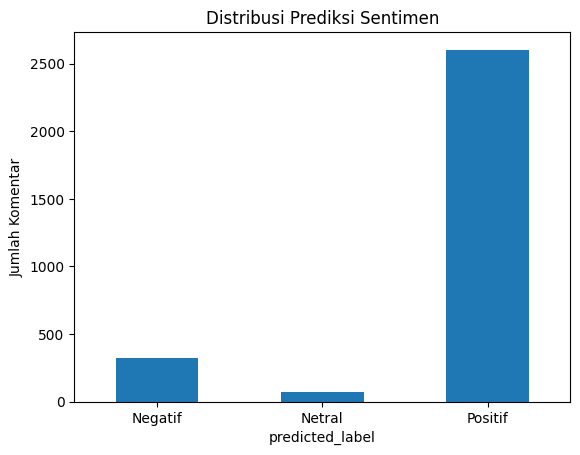

In [20]:
df['predicted_label'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0, 1, 2], ['Negatif', 'Netral', 'Positif'], rotation=0)
plt.title('Distribusi Prediksi Sentimen')
plt.ylabel('Jumlah Komentar')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
cm = confusion_matrix(y_test, y_pred_classes)

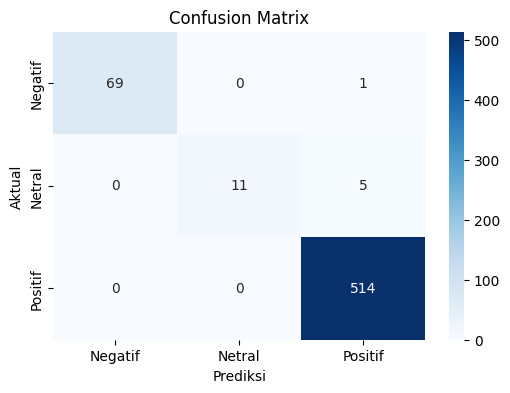

In [24]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

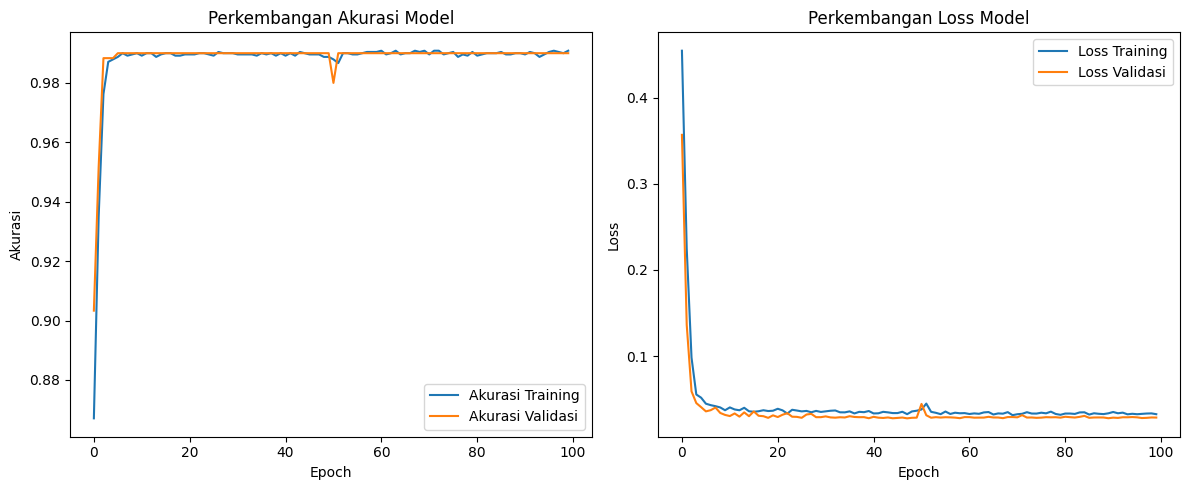

In [25]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Perkembangan Akurasi Model')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perkembangan Loss Model')
plt.legend()

plt.tight_layout()
plt.show()